# DAT300 - Compulsory Assignment 3
Stian Teien & Kristian Riksheim - Group19 - g19

## Notebook structure:
* Importing data
* Looking at y and x data
* Set up model and train it
* Further work

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import math

import seaborn as sns

import pyprind
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier 
from sklearn.linear_model import Perceptron
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dat300-h2020-ca3/X_train_250.csv
/kaggle/input/dat300-h2020-ca3/sample_solution.csv
/kaggle/input/dat300-h2020-ca3/X_test_100.csv
/kaggle/input/dat300-h2020-ca3/y_train_250.csv


# Upload data
This is a huge dataset that will not fit into my memory because the memory has a limit of 500 000 rows.  
To just get 500 000 rows for each time in memory we can use chuncksize og 500 000.  

The images are 50615 pixels (or rows) big, but that does not matter because we'll analyse each pixel sepratly and not as an image.  
We know have 50615 * 250 = 12 653 750 rows meaning we can iterate 25 times before it ends.

In [64]:
y_data = pd.read_csv('/kaggle/input/dat300-h2020-ca3/y_train_250.csv')
x_data_iterator = pd.read_csv('/kaggle/input/dat300-h2020-ca3/X_train_250.csv', chunksize=500000)
y_data_iterator = pd.read_csv('/kaggle/input/dat300-h2020-ca3/y_train_250.csv', chunksize=500000)

In [3]:
# Get a chunck of our data

def get_chunck():
    for batch in (x_data_iterator):
        x_train = (np.array(batch))
        break
            
    for batch in (y_data_iterator):
        y_train = (np.array(batch))
        break

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    return x_train, y_train

In [4]:
# Will iterate 10 times. That we think will be representative for the dataset

scalar = preprocessing.StandardScaler()
p1bar = pyprind.ProgBar(10)
for i in range(10):
    x,y = get_chunck()
    scalar.partial_fit(x,y)
    p1bar.update()

0% [##########] 100% | ETA: 00:00:00
Total time elapsed: 00:01:04


In [5]:
scalar.mean_

array([0.29631878, 4.17368596, 0.01052366, 0.72399953, 1.96245402,
       0.13906927, 1.89152009, 0.2414656 , 0.22422045, 0.32128032,
       0.19849883, 1.46461996, 0.02439269, 0.26126926, 0.04023517,
       0.29360154, 2.00052706, 0.76230256, 0.80174148, 0.0134957 ,
       2.90411132, 0.23985397, 0.34255256, 2.08557085, 0.2828483 ,
       0.2496633 , 2.98684717, 0.74905777, 1.8208621 , 0.02826522,
       0.94030013, 0.50487904, 3.61874919, 1.56994109, 4.51772065,
       0.97445089, 0.03716846, 0.41272329, 0.43980356, 2.0612834 ,
       0.69938662, 2.33153705, 0.52978061, 0.22036762, 3.0190408 ,
       0.25970477, 0.37710648, 0.07538257, 0.13640359, 0.01518566,
       1.43682309, 1.9475547 , 0.14968129, 0.02943484, 0.01072775,
       0.71594483, 1.3021953 , 0.3124364 , 0.00737955, 0.78419675,
       0.24466997, 0.22149439, 1.22897323, 0.86068397])

## Take a look at y data
See if we can see how the images are and how the tumor could look like.  
Split up in images and reshape them as an image

In [9]:
# Make y data ready and show it

y_train_img = []
img_size = 50615
amount_of_images = y_data.shape[0]/img_size
for i in range(0, int(math.floor(amount_of_images))):
    y_train_img.append(np.reshape(y_data.target[i*img_size:(i+1)*img_size].to_numpy(), (191, 265)))
    
y_train_img = np.array(y_train_img)
print(f"y-shape: {y_train_img.shape}")
print("\n\nPicture of the tumor :S")
plt.imshow(y_train_img[111], cmap='Reds')
plt.show()

y-shape: (250, 191, 265)


Picture of the tumor :S


### Disp of y-data
Here we need to see the how the classes balance is.  
This could be hard to do with using chuncks, but luckly the y-data is fitable in the memory  

If the classes are uneven we can see exatly how uneven proposinal to the whole dataset.

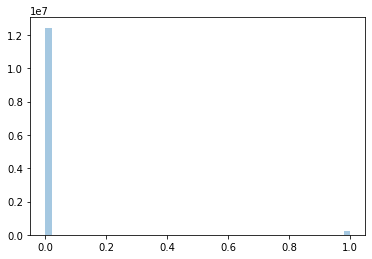

In [10]:
sns.distplot(y_data, kde=False)

In [11]:
y_data.target.value_counts()

0.0    12440454
1.0      213296
Name: target, dtype: int64

Her har vi en utrolig skjevfordeling av classene der 0 er klart mye mer enn 1  
Totalt 12440454 + 213296 = 12653750 datapunkter  
Der er 1.686 % er pixler med kreft.  
Ved slik skjevfordeling må vi være ganske presis med hvordan vi måler - og en veldig god løsning på det er å bruke f1 score

## Take a look at X-data
See if there is any outlayers and have a breif look at the disp of the data

In [65]:
# ta en titt på x_data
x,y = get_chunck()

In [66]:
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(25,20))
for i in range(64):
    axes[i//8,i%8] = sns.distplot(x[:,i] ,ax=axes[i//8,i%8], kde=False)
    axes[i//8,i%8].set_title(f"L{i+1}")
    axes[i//8,i%8].get_xaxis().set_visible(False)
    axes[i//8,i%8].get_yaxis().set_visible(False)


## Take a look at X-data with active tumor
Since there is sooo many pixel with no tumor we can't realy see what data is in the "tumoractived"-area.  
We extract only the areas with tumor and take a look at the X-data  

Se på L10 f.eks: Her er det mye på hele bildet med på tumor'en er det kun en verdi uten stor variasjon (og L5 og L35)  
Hva kan man trekke ut av det? At alle 1 er en verdi men med 0 har det variasjon - Vi kan trekke dette ut av datasette (men det får bli senere)

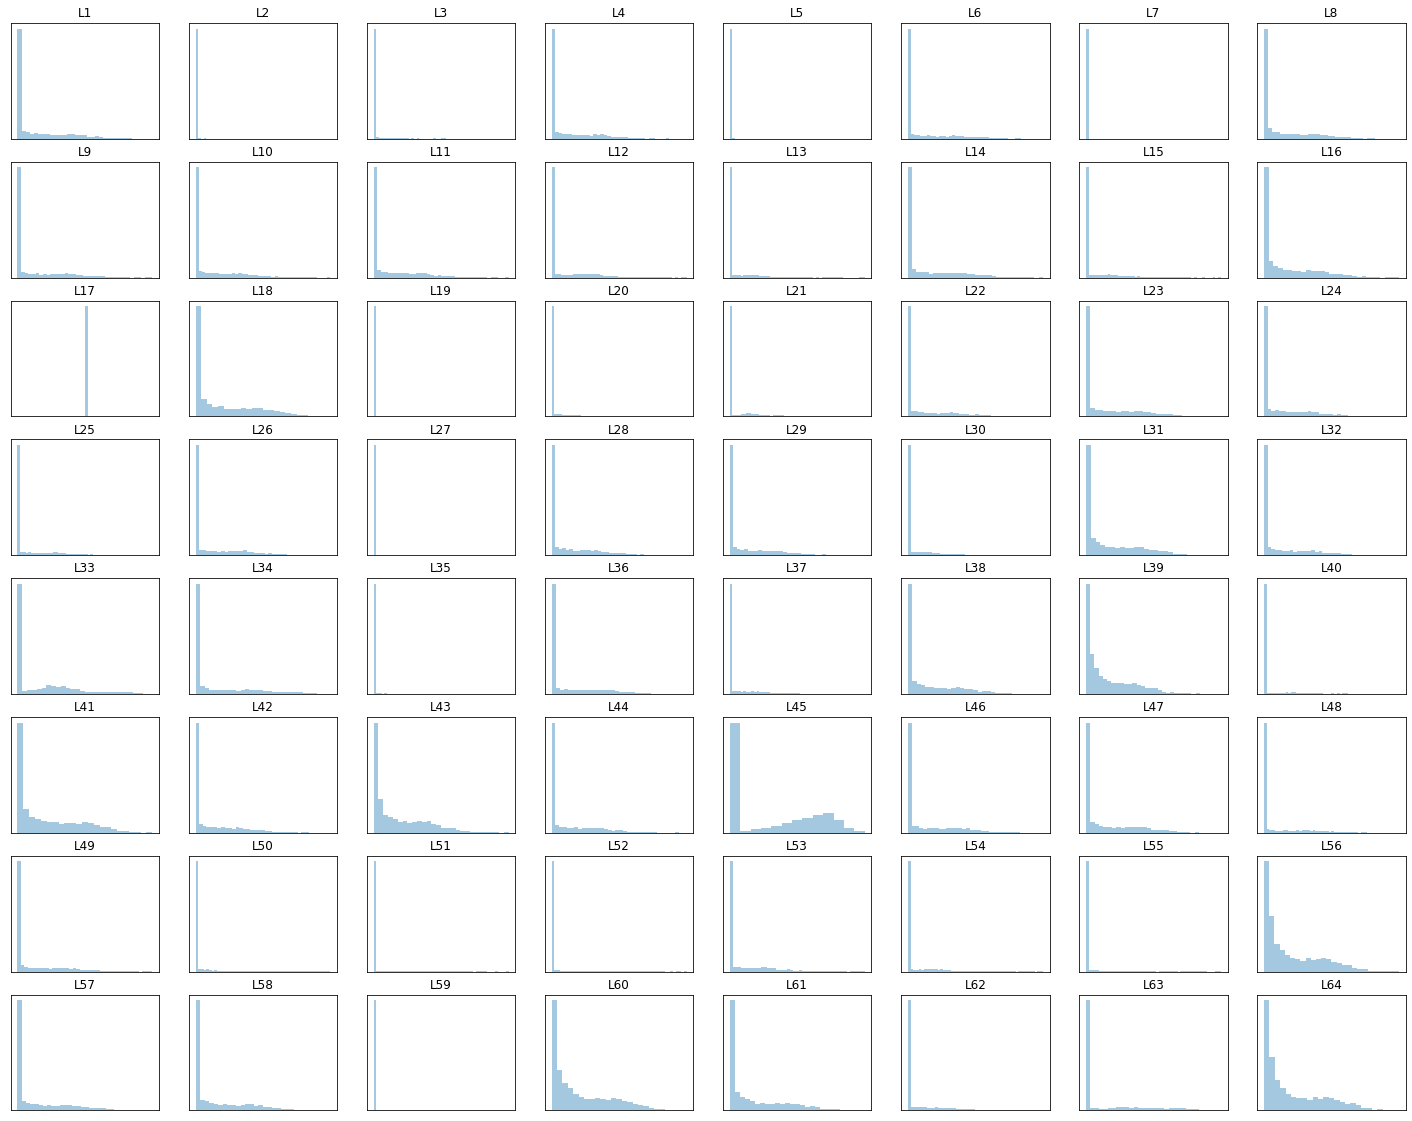

In [67]:
tumor_area = np.argwhere(y > .5)
tumor_pixel = []

for i in range(len(tumor_area)):
    tumor_pixel.append(x[tumor_area[i][0]])
    
tumor_pixel = np.array(tumor_pixel)

# Print it out
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(25,20))
for i in range(64):
    axes[i//8,i%8] = sns.distplot(tumor_pixel[:,i] ,ax=axes[i//8,i%8], kde=False)
    axes[i//8,i%8].set_title(f"L{i+1}")
    axes[i//8,i%8].get_xaxis().set_visible(False)
    axes[i//8,i%8].get_yaxis().set_visible(False)

## Heatmap
Cant really use it and don't see a connection with the data from last figure..

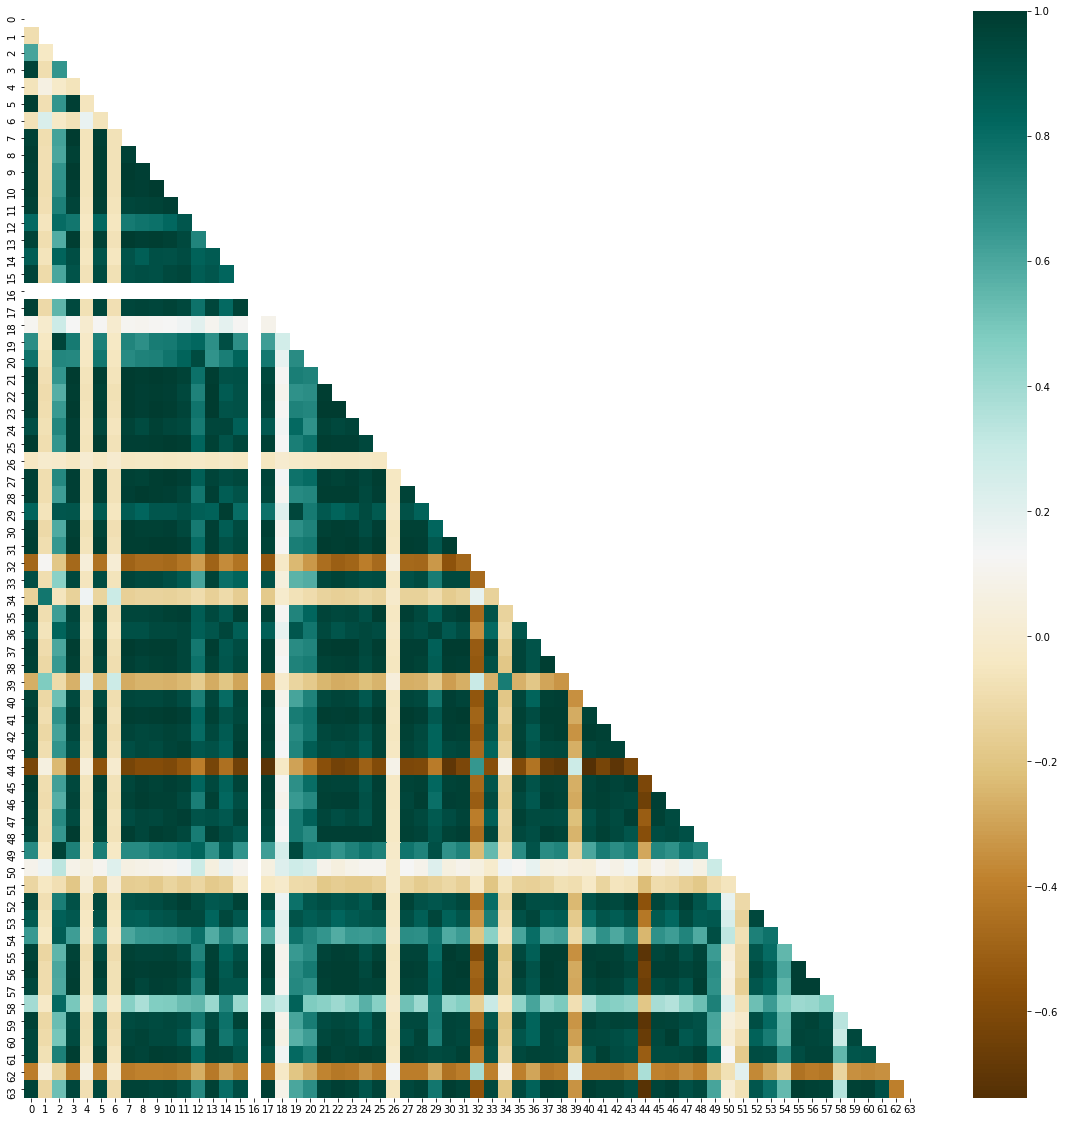

In [68]:
a = pd.DataFrame(tumor_pixel)
mask = np.triu(np.ones_like(a.corr(), dtype=np.bool))
plt.figure(figsize=(20, 20))
sns.heatmap(a.corr(), cmap='BrBG', mask=mask)

# Train model
Use a sklearn method:  
Will try out  
`Perceptron`  
`SGDclassifier`  
`PassiveAggressiveClassifier`  

They have partical_fit


In [12]:
# Reset iterator
x_data_iterator = pd.read_csv('/kaggle/input/dat300-h2020-ca3/X_train_250.csv', chunksize=500000)
y_data_iterator = pd.read_csv('/kaggle/input/dat300-h2020-ca3/y_train_250.csv', chunksize=500000)

In [13]:
sgd = SGDClassifier(random_state=42)
pac = PassiveAggressiveClassifier(C=0.00075, random_state=42) # Credit to group Fugletribunalet for good input :)
per = Perceptron(random_state=42)

f1_train = []
f1_val = []
f1_test = []

model = pac

## How many chuncks of data do we need to train in?
When do the model don't get any better. This we'll take a look at with a learning curve!  
Here we have to be a little carefull. If we split dete data up as usally it migth be that not both classes will be in the same dataset!  
Since there is under ~ 1.7% cancer datapoints.  
To take a look at this we need train set, validation set and a test set with new chuncks!

Let's set up a learning curv with k fold validaton to see how it preform  
Need to have at least two classes in each k fold.

In [14]:


fig = plt.figure()
plt.title('Learning curve')
plt.xlabel("Training examples")
plt.ylabel("f1_score")

x,y = get_chunck()

train_sizes, train_scores, test_scores = learning_curve(model, scalar.transform(x), y.ravel(), train_sizes=np.linspace(0.1, 1.0, 10), scoring='f1')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1,color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="f1 score")
plt.legend(loc="best")


As we can see from the learning curve with k fold cross validation the f1_score is quickly good.  
This means we don't need to train the data over a lot of chuncks.

## Set up pipelines to find best parameters
Uses gridsearchcv  
Best results for PAC - {'C': 0.006206934482758621}  
Best results for SGD - {'alpha': 1e-05, 'loss': 'log', 'penalty': 'l1'}

In [62]:
model = PassiveAggressiveClassifier(random_state=42)
parameters = {'C': [i for i in np.linspace(0.0001, 0.01, 10)]}

#model = SGDClassifier(random_state=42)
#parameters = {'loss': ['hinge', 'log'],
#             'penalty': ['l1', 'l2'],
#             'alpha': [i for i in np.linspace(0.00001, 0.001, 10)]}

clf = GridSearchCV(model, parameters, scoring='f1', verbose=1)

x,y = get_chunck()
clf.fit(scalar.transform(x), y.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.8min finished


GridSearchCV(estimator=PassiveAggressiveClassifier(random_state=42),
             param_grid={'C': [1e-07, 0.00011119999999999999,
                               0.00022229999999999998, 0.00033339999999999997,
                               0.00044449999999999996, 0.0005556,
                               0.0006666999999999999, 0.0007777999999999998,
                               0.0008888999999999999, 0.001]},
             scoring='f1', verbose=1)

In [63]:
clf.best_params_

{'C': 0.001}

## Set up model with best params
One for SGD and one for PAC.
Train on some data and validate on some other. The best results wins.

In [51]:
# Reset iterator
x_data_iterator = pd.read_csv('/kaggle/input/dat300-h2020-ca3/X_train_250.csv', chunksize=500000)
y_data_iterator = pd.read_csv('/kaggle/input/dat300-h2020-ca3/y_train_250.csv', chunksize=500000)

In [53]:
# Train
params_sgd = {'alpha': 1e-05, 'loss': 'log', 'penalty': 'l1', 'random_state':42}
params_pac = {'C': 0.006206934482758621,'random_state':42}
x,y = get_chunck()
model_sgd = SGDClassifier(**params_sgd)
model_pac = PassiveAggressiveClassifier(**params_pac)

model_sgd.partial_fit(scalar.transform(x),y.ravel(), classes=range(2))
model_pac.partial_fit(scalar.transform(x),y.ravel(), classes=range(2))


PassiveAggressiveClassifier(C=0.006206934482758621, random_state=42)

In [55]:
# Validate on new untrained data
f1_val_sgd = []
f1_val_pac = []
for _ in range(5):
    x,y = get_chunck()
    pred = model_sgd.predict(scalar.transform(x))
    f1_val_sgd.append(f1_score(pred, y))
    
    pred = model_pac.predict(scalar.transform(x))
    f1_val_pac.append(f1_score(pred, y))
    

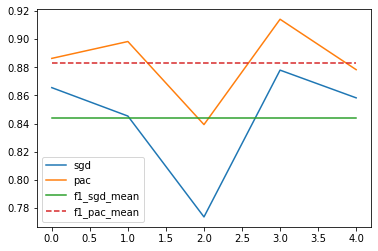

In [60]:
plt.plot(f1_val_sgd, label="sgd")
plt.plot(f1_val_pac, label="pac")
plt.plot([np.mean(f1_val_sgd) for _ in range(len(f1_val_sgd))],'-', label="f1_sgd_mean")
plt.plot([np.mean(f1_val_pac) for _ in range(len(f1_val_pac))],'--', label="f1_pac_mean")
plt.legend()


## Picking a model based on best F1 score 
and it is PAC!  
Use that to deliver code

In [69]:
model = model_pac

# Save prediction and download
Load the test set, make a prediction and download to kaggle comp. 🎉

In [70]:
x_pred = []
x_test_iterator = pd.read_csv('/kaggle/input/dat300-h2020-ca3/X_test_100.csv', chunksize=50615)
pbar = pyprind.ProgBar(100)

for i, batch in enumerate(x_test_iterator):
    pred = model.predict(scalar.transform(batch))
    for j in pred:
        if j < .5:
            x_pred.append(False)
        else:
            x_pred.append(True)        
    pbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:04


In [71]:
x_pred_df = pd.DataFrame(x_pred, columns=["Predicted"])
x_pred_df = x_pred_df.reset_index()
x_pred_df = x_pred_df.rename(columns={'index':'Id'})
x_pred_df.to_csv('pred.csv', index=False)

# Videre arbeid - trekke ut kun det viktige
En ide kan være å filtere ut data som omligger kreften og kun bruke de. For det virker som det er data i kanten av svulsten den sliter med å klassifisere riktig :)

In [72]:
x,y = get_chunck()
y=y[0]
y = np.reshape(y, (191, 265))

plt.imshow(y, cmap="Reds")

TypeError: get_chunck() takes 0 positional arguments but 1 was given

In [ ]:
x_coords = []
y_coords = []

for i in range(191):
    if max(y[i,:]) == 1:
        y_coords.append(i)
        
for i in range(265):
    if max(y[:,i]) == 1:
        x_coords.append(i)
        
plt.imshow(y[y_coords[0]:y_coords[-1]], cmap="Reds")
plt.show()
plt.imshow(y[y_coords[0]:y_coords[-1], x_coords[0]:x_coords[-1]], cmap="Reds")
plt.show()


## Ønsker å ha rundtliggende pixler også
Det kan vi gjøre ved å doble arealet til bildet. 

In [ ]:
ny_lengde = math.ceil(math.sqrt(2*len(x_coords)*len(y_coords)))
x_add = int(math.ceil(len(x_coords) - ny_lengde/2))
y_add = int(math.ceil(len(y_coords) - ny_lengde/2))
ny_x = [i for i in range(x_coords[0] - x_add, x_coords[-1] + x_add)]
ny_y = [i for i in range(y_coords[0] - y_add, y_coords[-1] + y_add)]

plt.imshow(y[ny_y[0]:ny_y[-1], ny_x[0]:ny_x[-1]], cmap="Reds")

## Sette opp en pipeline
For å trene på mange nedkorteteede bilder

In [ ]:
def get_reduse_images(n_images):
    red_y = []
    red_x = []
    x_data,y_data = get_chunck(n_images)
    
    for j,y in enumerate(y_data):
        y = np.reshape(y, (191, 265))
        x_coords = []
        y_coords = []
        for i in range(191):
            if max(y[i,:]) == 1:
                y_coords.append(i)

        for i in range(265):
            if max(y[:,i]) == 1:
                x_coords.append(i)
                
        ny_lengde = math.ceil(math.sqrt(2*len(x_coords)*len(y_coords)))
        x_add = int(math.ceil(len(x_coords) - ny_lengde/2))
        y_add = int(math.ceil(len(y_coords) - ny_lengde/2))
        ny_x = [i for i in range(x_coords[0] - x_add, x_coords[-1] + x_add)]
        ny_y = [i for i in range(y_coords[0] - y_add, y_coords[-1] + y_add)]
        
        y = y[ny_y[0]:ny_y[-1], ny_x[0]:ny_x[-1]]
        x = np.reshape(x_data[j], (191, 265, 64))
        x = x[ny_y[0]:ny_y[-1], ny_x[0]:ny_x[-1]]
          
        red_y.append(y)
        red_x.append(x)
    

    red_y = np.array(red_y)
    red_x = np.array(red_x)

    
    return red_x, red_y
        

In [ ]:
def get_half_images(n_images):
    x_data,y_data = get_chunck(n_images)
    
    red_y = []
    red_x = []
   
    ny_x = [i for i in range(47, 143)]
    ny_y = [i for i in range(66, 198)]
    
    for j,y in enumerate(y_data):
        y = np.reshape(y, (191, 265))
        y = y[ny_y[0]:ny_y[-1], ny_x[0]:ny_x[-1]]
        x = np.reshape(x_data[j], (191, 265, 64))
        x = x[ny_y[0]:ny_y[-1], ny_x[0]:ny_x[-1]]

        
        red_y.append(np.reshape(y, (y.shape[0]*y.shape[1], )))
        red_x.append(np.reshape(x, (x.shape[0]*x.shape[1], 64)))
    
    red_y = np.array(red_y)
    red_x = np.array(red_x)

    return red_x, red_y
        

## Train model on redused data

In [ ]:
# Reset iterator
x_data_iterator = pd.read_csv('/kaggle/input/dat300-h2020-ca3/X_train_250.csv', chunksize=50615)
y_data_iterator = pd.read_csv('/kaggle/input/dat300-h2020-ca3/y_train_250.csv', chunksize=50615)

In [ ]:
model = PassiveAggressiveClassifier(C=0.00075, random_state=42)
f1 = []
f1_val = []

In [ ]:
# Train model on half images

runder = 250
p1bar = pyprind.ProgBar(runder)
for _ in range(runder):
    x,y = get_half_images(n_images=1)
    for i, x_batch in enumerate(x):
        model.partial_fit(scalar.transform(x_batch), y[i], classes=range(2))
        pred = model.predict(scalar.transform(x_batch))
        f1.append(f1_score(pred,y[i]))
    
        
    p1bar.update()


In [ ]:
# Eval / test
runder = 250
p1bar = pyprind.ProgBar(runder)
for _ in range(runder):
    x,y = get_chunck(n_images=1)
    for i, x_batch in enumerate(x):
        pred = model.predict(scalar.transform(x[i]))
        f1_val.append(f1_score(pred, y[i]))
        
    p1bar.update()

In [ ]:
plt.plot(f1, label="F1")
plt.plot(f1_val, label="F1_val_newImg")
plt.legend()
plt.show()

# Konklunsjon på dette sidesportet
Det virker som om modellen ikke klarer å se helheten når den kun får halvparten. Det gjør at den tror det svultser over alt.. 
Modellen ble iallefall sjukt god på å finne det rundt, men totaltsett ganske dårlig..  
Tanken var å kunne balansere settet litt mer kun ved å ta det rundt, men det gikk sånn halveis  
Det som skjer er at den ikke klarer ting utenfor det trente bildet og gjetter helt feil.

La oss printe noen bilder av det modellen foreslår så ser man det litt tydligere  
Så det ser ut som det kun er noen den sliter på.. Det ser man klart på f1.

In [ ]:
x,y = get_chunck(n_images=4)
y_pred = [model.predict(scalar.transform(i)) for i in x]

for i,b in enumerate(y_pred):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(np.reshape(y_pred[i], (191,265)), cmap="Reds")
    axarr[0].set_title('Predicted')
    axarr[1].imshow(np.reshape(y[i], (191,265)), cmap="Reds")
    axarr[1].set_title('True')
    plt.show()
    